🤖 Notebook 2 - Modelagem Inteligente para Dados Desbalanceados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import multilabel_confusion_matrix
import joblib
import warnings
import os
warnings.filterwarnings('ignore')

print("Modelagem para Manutenção Preditiva")
print("="*55)

# Carregar dados processados
X = pd.read_csv('../data/X_processed.csv')
y = pd.read_csv('../data/y_processed.csv')
feature_names = joblib.load('../data/feature_names.pkl')
failure_names = ['FDF', 'FDC', 'FP', 'FTE', 'FA']

print(f"Dados carregados: {X.shape[0]:,} amostras, {X.shape[1]} features")
print(f"Alvo: prever {y.shape[1]} tipos de falha simultaneamente")

Modelagem para Manutenção Preditiva
Dados carregados: 35,260 amostras, 13 features
Alvo: prever 5 tipos de falha simultaneamente


In [2]:
# ===== 1. Estratégia para desbalanceamento =====
print("\n[1] Visão das frequências (desbalanceamento)")
print("-"*55)

for i, name in enumerate(failure_names):
    casos = y.iloc[:, i].sum()
    taxa = casos / len(y) * 100
    print(f"- {name}: {casos} casos ({taxa:.2f}%)")

print("\nEstratégia escolhida:")
print("1) Split estratificado quando possível")
print("2) Random Forest com class_weight='balanced'")
print("3) Foco em recall (reduzir falsos negativos)")
print("4) Otimização de threshold por tipo")
print("5) Cross-validation para checar estabilidade")


[1] Visão das frequências (desbalanceamento)
-------------------------------------------------------
- FDF: 141 casos (0.40%)
- FDC: 925 casos (2.62%)
- FP: 126 casos (0.36%)
- FTE: 170 casos (0.48%)
- FA: 144 casos (0.41%)

Estratégia escolhida:
1) Split estratificado quando possível
2) Random Forest com class_weight='balanced'
3) Foco em recall (reduzir falsos negativos)
4) Otimização de threshold por tipo
5) Cross-validation para checar estabilidade


In [3]:
# ===== 2. Split =====
print("\n[2] Divisão treino/teste")
print("-"*45)

# Combinação das falhas para tentar estratificar
y_combined = y.apply(lambda row: ''.join(row.astype(str)), axis=1)
print(f"Combinações únicas de rótulos: {y_combined.nunique()}")

print("Top 5 combinações:")
print(y_combined.value_counts().head())

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_combined
    )
    print("\nSplit estratificado realizado.")
except Exception as e:
    print("\nSplit simples (estratificado não foi possível).")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

print(f"Treino: {X_train.shape[0]:,} | Teste: {X_test.shape[0]:,}")

print("\nChecando proporções no train/test:")
for i, name in enumerate(failure_names):
    train_casos = y_train.iloc[:, i].sum()
    test_casos = y_test.iloc[:, i].sum()
    train_pct = train_casos / len(y_train) * 100
    test_pct = test_casos / len(y_test) * 100
    status = "OK" if abs(train_pct - test_pct) < 1.0 else "Atenção"
    print(f"- {name}: {train_pct:.2f}% → {test_pct:.2f}% ({status})")


[2] Divisão treino/teste
---------------------------------------------
Combinações únicas de rótulos: 15
Top 5 combinações:
00000    33782
01000      909
00010      151
00001      140
10000      135
Name: count, dtype: int64

Split simples (estratificado não foi possível).
Treino: 28,208 | Teste: 7,052

Checando proporções no train/test:
- FDF: 0.41% → 0.35% (OK)
- FDC: 2.57% → 2.82% (OK)
- FP: 0.38% → 0.27% (OK)
- FTE: 0.47% → 0.52% (OK)
- FA: 0.40% → 0.44% (OK)


In [4]:
# ===== 3. Baseline =====
print("\n[3] Baseline (sempre 'sem falha')")
print("-"*50)

baseline_pred = np.zeros_like(y_test.values)
baseline_f1_scores = []

for i, name in enumerate(failure_names):
    f1 = f1_score(y_test.iloc[:, i], baseline_pred[:, i], zero_division=0)
    baseline_f1_scores.append(f1)
    print(f"- {name}: F1 = {f1:.3f}")

baseline_f1_avg = np.mean(baseline_f1_scores)
print(f"\nF1 médio baseline: {baseline_f1_avg:.3f}")


[3] Baseline (sempre 'sem falha')
--------------------------------------------------
- FDF: F1 = 0.000
- FDC: F1 = 0.000
- FP: F1 = 0.000
- FTE: F1 = 0.000
- FA: F1 = 0.000

F1 médio baseline: 0.000


In [5]:
# ===== 4. RF vs XGBoost =====
print("\n[4] Comparando Random Forest e XGBoost")
print("-"*48)

import xgboost as xgb

print("Treinando Random Forest...")
rf_otimizado = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
modelo_rf = MultiOutputClassifier(rf_otimizado, n_jobs=-1)
modelo_rf.fit(X_train, y_train)
print("Random Forest treinado.")

# Predições RF
rf_pred = modelo_rf.predict(X_test)
rf_pred_proba = modelo_rf.predict_proba(X_test)

rf_pred_proba_clean = np.zeros((len(y_test), len(failure_names)))
for i in range(len(failure_names)):
    rf_pred_proba_clean[:, i] = rf_pred_proba[i][:, 1]

print("\nTreinando XGBoost (um por alvo)...")
xgb_models = {}
xgb_pred = np.zeros_like(y_test.values)
xgb_pred_proba_list = []

def calc_scale_pos_weight(y_col):
    neg = (y_col == 0).sum()
    pos = (y_col == 1).sum()
    return neg / max(pos, 1)

for i, name in enumerate(failure_names):
    scale_weight = calc_scale_pos_weight(y_train.iloc[:, i])
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_weight,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train.iloc[:, i])
    xgb_pred[:, i] = xgb_model.predict(X_test)
    xgb_pred_proba_list.append(xgb_model.predict_proba(X_test)[:, 1])
    xgb_models[name] = xgb_model

xgb_pred_proba_clean = np.array(xgb_pred_proba_list).T
print("XGBoost treinado.")

print("\nComparação inicial (threshold = 0.5):")
print("-"*50)
print(f"{'Tipo':<4} | {'RF F1':>6} | {'XGB F1':>7} | {'Melhor':>8}")
print("-"*50)

rf_f1_scores, xgb_f1_scores = [], []

for i, name in enumerate(failure_names):
    rf_f1 = f1_score(y_test.iloc[:, i], rf_pred[:, i], zero_division=0)
    xgb_f1 = f1_score(y_test.iloc[:, i], xgb_pred[:, i], zero_division=0)
    rf_f1_scores.append(rf_f1)
    xgb_f1_scores.append(xgb_f1)
    melhor = "XGB" if xgb_f1 > rf_f1 else "RF"
    print(f"{name:<4} | {rf_f1:>6.3f} | {xgb_f1:>7.3f} | {melhor:>8}")

rf_f1_avg = np.mean(rf_f1_scores)
xgb_f1_avg = np.mean(xgb_f1_scores)

print("-"*50)
print(f"MÉDIO| {rf_f1_avg:>6.3f} | {xgb_f1_avg:>7.3f} | {'XGB' if xgb_f1_avg > rf_f1_avg else 'RF':>8}")

# Escolher vencedor
if xgb_f1_avg > rf_f1_avg:
    melhor_modelo_nome = "XGBoost"
    melhor_modelo = xgb_models
    melhor_pred = xgb_pred
    melhor_pred_proba = xgb_pred_proba_clean
    melhor_f1_scores = xgb_f1_scores
    melhor_f1_avg = xgb_f1_avg
    modelo_tipo = "individual"
else:
    melhor_modelo_nome = "Random Forest"
    melhor_modelo = modelo_rf
    melhor_pred = rf_pred
    melhor_pred_proba = rf_pred_proba_clean
    melhor_f1_scores = rf_f1_scores
    melhor_f1_avg = rf_f1_avg
    modelo_tipo = "multioutput"

print(f"\nVencedor: {melhor_modelo_nome}")
print(f"F1 médio: {melhor_f1_avg:.3f}")

if baseline_f1_avg > 0:
    melhoria_pct = (melhor_f1_avg - baseline_f1_avg) / baseline_f1_avg * 100
    print(f"Melhoria vs baseline: {melhor_f1_avg - baseline_f1_avg:.3f} ({melhoria_pct:.1f}%)")
else:
    print(f"Melhoria vs baseline: {melhor_f1_avg - baseline_f1_avg:.3f} (baseline = 0)")


[4] Comparando Random Forest e XGBoost
------------------------------------------------
Treinando Random Forest...
Random Forest treinado.

Treinando XGBoost (um por alvo)...
XGBoost treinado.

Comparação inicial (threshold = 0.5):
--------------------------------------------------
Tipo |  RF F1 |  XGB F1 |   Melhor
--------------------------------------------------
FDF  |  0.000 |   0.000 |       RF
FDC  |  0.156 |   0.173 |      XGB
FP   |  0.467 |   0.389 |       RF
FTE  |  0.340 |   0.415 |      XGB
FA   |  0.000 |   0.000 |       RF
--------------------------------------------------
MÉDIO|  0.193 |   0.195 |      XGB

Vencedor: XGBoost
F1 médio: 0.195
Melhoria vs baseline: 0.195 (baseline = 0)


In [6]:
# ===== 5. Otimização de thresholds =====
print("\n[5] Otimizando thresholds por tipo")
print("-"*45)

def encontrar_melhor_threshold(y_true, y_proba, tipo_nome):
    """Threshold que maximiza F1 por tipo."""
    if tipo_nome in ['FDF', 'FA']:
        thresholds = np.arange(0.05, 0.5, 0.05)
    else:
        thresholds = np.arange(0.1, 0.8, 0.05)
    melhor_f1, melhor_threshold = 0, 0.5
    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        f1 = f1_score(y_true, y_pred_thr, zero_division=0)
        if f1 > melhor_f1:
            melhor_f1, melhor_threshold = f1, thr
    return melhor_threshold, melhor_f1

print(f"Otimizando thresholds para {melhor_modelo_nome}...")
thresholds_otimizados, f1_scores_otimizados = [], []

for i, name in enumerate(failure_names):
    thr_opt, f1_opt = encontrar_melhor_threshold(
        y_test.iloc[:, i], melhor_pred_proba[:, i], name
    )
    thresholds_otimizados.append(thr_opt)
    f1_scores_otimizados.append(f1_opt)
    f1_original = melhor_f1_scores[i]
    print(f"- {name}: thr={thr_opt:.2f} | F1: {f1_original:.3f} → {f1_opt:.3f} ({f1_opt - f1_original:+.3f})")

f1_final_avg = np.mean(f1_scores_otimizados)
if baseline_f1_avg > 0:
    melhoria_total_pct = (f1_final_avg - baseline_f1_avg) / baseline_f1_avg * 100
    melhoria_total_str = f"{melhoria_total_pct:.1f}%"
else:
    melhoria_total_str = "baseline = 0"

print(f"\nF1 médio final (com thresholds): {f1_final_avg:.3f}")
print(f"Melhoria total vs baseline: {f1_final_avg - baseline_f1_avg:.3f} ({melhoria_total_str})")

# Comparação com o outro modelo (sem otimização)
if melhor_modelo_nome == "XGBoost":
    modelo_perdedor = "Random Forest"
    f1_perdedor = rf_f1_avg
else:
    modelo_perdedor = "XGBoost"
    f1_perdedor = xgb_f1_avg

print("\nComparação final:")
print(f"- {melhor_modelo_nome} (com thresholds): {f1_final_avg:.3f}")
print(f"- {modelo_perdedor} (threshold=0.5): {f1_perdedor:.3f}")
print(f"- Vantagem: {f1_final_avg - f1_perdedor:.3f} ponto(s) de F1")


[5] Otimizando thresholds por tipo
---------------------------------------------
Otimizando thresholds para XGBoost...
- FDF: thr=0.10 | F1: 0.000 → 0.060 (+0.060)
- FDC: thr=0.55 | F1: 0.173 → 0.177 (+0.004)
- FP: thr=0.30 | F1: 0.389 → 0.450 (+0.061)
- FTE: thr=0.60 | F1: 0.415 → 0.423 (+0.008)
- FA: thr=0.50 | F1: 0.000 → 0.000 (+0.000)

F1 médio final (com thresholds): 0.222
Melhoria total vs baseline: 0.222 (baseline = 0)

Comparação final:
- XGBoost (com thresholds): 0.222
- Random Forest (threshold=0.5): 0.193
- Vantagem: 0.029 ponto(s) de F1



📊 COMPARAÇÃO VISUAL DETALHADA: RF vs XGBOOST


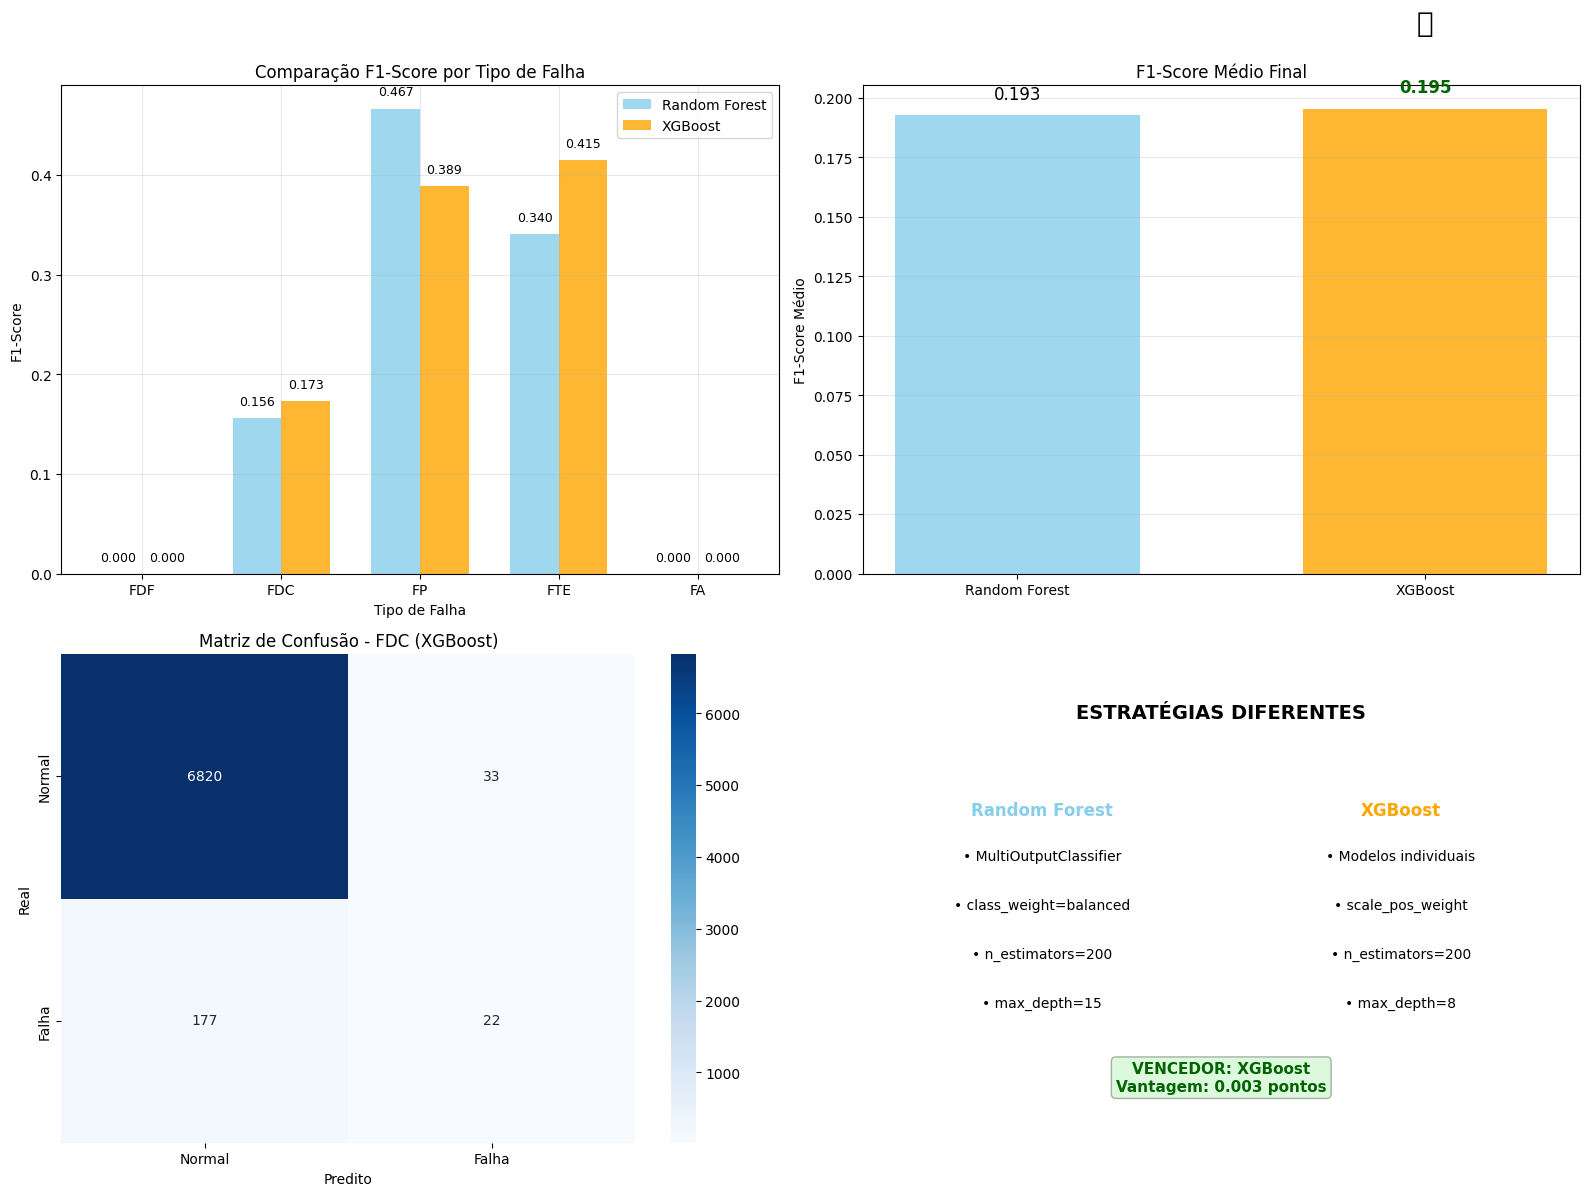

In [7]:
# ===== COMPARAÇÃO VISUAL DETALHADA DOS MODELOS =====
print("\n" + "="*60)
print("📊 COMPARAÇÃO VISUAL DETALHADA: RF vs XGBOOST")
print("="*60)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Comparação lado a lado
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: F1-Score por tipo
tipos_x = np.arange(len(failure_names))
largura = 0.35

bars1 = ax1.bar(tipos_x - largura/2, rf_f1_scores, largura, label='Random Forest', color='skyblue', alpha=0.8)
bars2 = ax1.bar(tipos_x + largura/2, xgb_f1_scores, largura, label='XGBoost', color='orange', alpha=0.8)

ax1.set_xlabel('Tipo de Falha')
ax1.set_ylabel('F1-Score')
ax1.set_title('Comparação F1-Score por Tipo de Falha')
ax1.set_xticks(tipos_x)
ax1.set_xticklabels(failure_names)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Valores nas barras
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01, f'{rf_f1_scores[i]:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.01, f'{xgb_f1_scores[i]:.3f}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: F1 médio
modelos = ['Random Forest', 'XGBoost']
f1_medios = [rf_f1_avg, xgb_f1_avg]
cores = ['skyblue', 'orange']

bars = ax2.bar(modelos, f1_medios, color=cores, alpha=0.8, width=0.6)
ax2.set_ylabel('F1-Score Médio')
ax2.set_title('F1-Score Médio Final')
ax2.grid(True, alpha=0.3, axis='y')

for i, (bar, f1) in enumerate(zip(bars, f1_medios)):
    cor_texto = 'darkgreen' if f1 == max(f1_medios) else 'black'
    peso = 'bold' if f1 == max(f1_medios) else 'normal'
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{f1:.3f}', ha='center', va='bottom', fontsize=12, color=cor_texto, fontweight=peso)

vencedor_idx = 0 if rf_f1_avg > xgb_f1_avg else 1
ax2.text(vencedor_idx, max(f1_medios) + 0.03, '👑', ha='center', va='bottom', fontsize=20)

# Gráfico 3: Matriz de confusão FDC
fdc_idx = 1
y_true_fdc = y_test.iloc[:, fdc_idx]
y_pred_fdc = rf_pred[:, fdc_idx] if melhor_modelo_nome=="Random Forest" else xgb_pred[:, fdc_idx]
cm_fdc = confusion_matrix(y_true_fdc, y_pred_fdc)

sns.heatmap(cm_fdc, annot=True, fmt='d', cmap='Blues', ax=ax3,
           xticklabels=['Normal', 'Falha'], yticklabels=['Normal', 'Falha'])
ax3.set_title(f'Matriz de Confusão - FDC ({melhor_modelo_nome})')
ax3.set_xlabel('Predito')
ax3.set_ylabel('Real')

# Gráfico 4: Estratégias
estrategias_data = {
    'Random Forest': ['MultiOutputClassifier', 'class_weight=balanced', 'n_estimators=200', 'max_depth=15'],
    'XGBoost': ['Modelos individuais', 'scale_pos_weight', 'n_estimators=200', 'max_depth=8']
}

ax4.axis('off')
ax4.text(0.5, 0.9, 'ESTRATÉGIAS DIFERENTES', ha='center', va='top', fontsize=14, fontweight='bold', transform=ax4.transAxes)

# RF
ax4.text(0.25, 0.7, 'Random Forest', ha='center', va='top', fontsize=12, fontweight='bold', color='skyblue', transform=ax4.transAxes)
for i, estrategia in enumerate(estrategias_data['Random Forest']):
    ax4.text(0.25, 0.6-i*0.1, f'• {estrategia}', ha='center', va='top', fontsize=10, transform=ax4.transAxes)

# XGBoost
ax4.text(0.75, 0.7, 'XGBoost', ha='center', va='top', fontsize=12, fontweight='bold', color='orange', transform=ax4.transAxes)
for i, estrategia in enumerate(estrategias_data['XGBoost']):
    ax4.text(0.75, 0.6-i*0.1, f'• {estrategia}', ha='center', va='top', fontsize=10, transform=ax4.transAxes)

resultado_texto = f"VENCEDOR: {melhor_modelo_nome}\nVantagem: {abs(rf_f1_avg - xgb_f1_avg):.3f} pontos"
ax4.text(0.5, 0.1, resultado_texto, ha='center', va='bottom', fontsize=11, fontweight='bold', color='darkgreen',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3), transform=ax4.transAxes)

plt.tight_layout()
plt.show()

In [8]:
# ===== 6. Cross-validation =====
print("\n[6] Cross-Validation (3 folds)")
print("-"*37)

from sklearn.model_selection import KFold
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
cv_f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
    print(f"Fold {fold}/3...")
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    if melhor_modelo_nome == "Random Forest":
        modelo_cv = MultiOutputClassifier(
            RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
            n_jobs=-1
        )
        modelo_cv.fit(X_fold_train, y_fold_train)
        pred_cv = modelo_cv.predict(X_fold_val)
    else:
        pred_cv = np.zeros_like(y_fold_val.values)
        for i, name in enumerate(failure_names):
            scale_weight = calc_scale_pos_weight(y_fold_train.iloc[:, i])
            xgb_cv = xgb.XGBClassifier(
                n_estimators=100,
                scale_pos_weight=scale_weight,
                random_state=42,
                eval_metric='logloss'
            )
            xgb_cv.fit(X_fold_train, y_fold_train.iloc[:, i])
            pred_cv[:, i] = xgb_cv.predict(X_fold_val)

    fold_f1 = np.mean([
        f1_score(y_fold_val.iloc[:, i], pred_cv[:, i], zero_division=0)
        for i in range(len(failure_names))
    ])
    cv_f1_scores.append(fold_f1)

cv_mean, cv_std = np.mean(cv_f1_scores), np.std(cv_f1_scores)
print(f"\nResultados CV ({melhor_modelo_nome}): F1 médio = {cv_mean:.3f} ± {cv_std:.3f}")
print(f"F1 no teste (com thresholds): {f1_final_avg:.3f}")

if abs(f1_final_avg - cv_mean) < 2 * cv_std:
    print("Estável (resultado dentro de 2 desvios-padrão).")
else:
    print("Atenção: possível instabilidade/overfitting.")


[6] Cross-Validation (3 folds)
-------------------------------------
Fold 1/3...
Fold 2/3...
Fold 3/3...

Resultados CV (XGBoost): F1 médio = 0.230 ± 0.008
F1 no teste (com thresholds): 0.222
Estável (resultado dentro de 2 desvios-padrão).



[7] Importância de variáveis
---------------------------------------------
Top 10 variáveis:
 1. torque               | 0.2341 | Original
 2. potencia_mecanica    | 0.1210 | Criada
 3. velocidade_rotacional | 0.0811 | Original
 4. desgaste_da_ferramenta | 0.0757 | Original
 5. taxa_desgaste        | 0.0721 | Criada
 6. tipo_H               | 0.0671 | Original
 7. stress_mecanico      | 0.0638 | Criada
 8. tipo_L               | 0.0612 | Original
 9. temperatura_processo | 0.0597 | Original
10. temperatura_ar       | 0.0593 | Original

Análise das features criadas:
- No Top 10: 3/4
OK


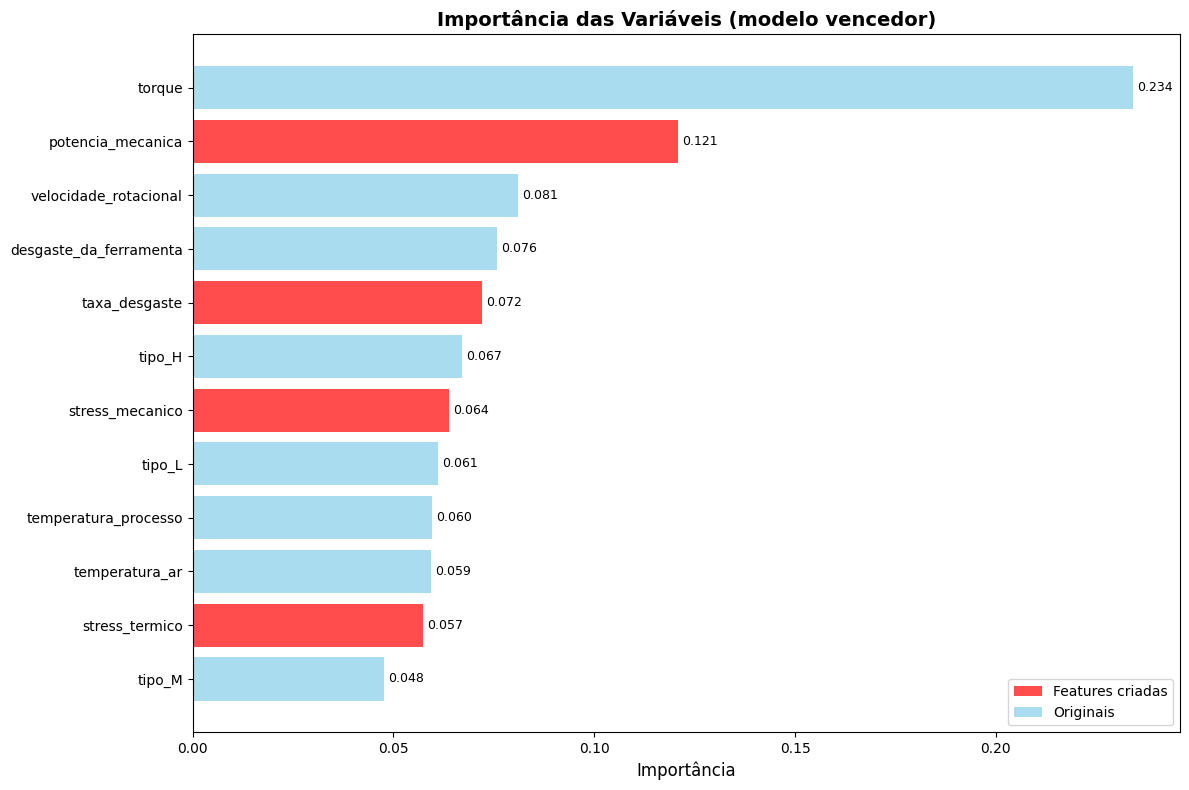

In [9]:
# ===== 7. Importância de variáveis =====
print("\n[7] Importância de variáveis")
print("-"*45)

if melhor_modelo_nome == "Random Forest":
    # média das importâncias dos estimadores (um por alvo)
    importances = np.mean([est.feature_importances_ for est in melhor_modelo.estimators_], axis=0)
else:
    # média dos 5 modelos XGB
    importances_list = [model.feature_importances_ for model in melhor_modelo.values()]
    importances = np.mean(importances_list, axis=0)

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 10 variáveis:")
for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
    tipo = "Criada" if row['feature'] in ['stress_termico', 'potencia_mecanica', 'taxa_desgaste', 'stress_mecanico'] else "Original"
    print(f"{i:2d}. {row['feature']:20} | {row['importance']:.4f} | {tipo}")

features_criadas = ['stress_termico', 'potencia_mecanica', 'taxa_desgaste', 'stress_mecanico']
features_criadas_top10 = len([f for f in feature_importance_df.head(10)['feature'] if f in features_criadas])

print("\nAnálise das features criadas:")
print(f"- No Top 10: {features_criadas_top10}/4")
print("OK" if features_criadas_top10 >= 2 else "Impacto limitado")

plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(12)
colors = ['red' if f in features_criadas else 'skyblue' for f in top_features['feature']]
bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importância', fontsize=12)
plt.title('Importância das Variáveis (modelo vencedor)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
for bar, imp in zip(bars, top_features['importance']):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{imp:.3f}', ha='left', va='center', fontsize=9)
from matplotlib.patches import Patch
plt.legend(handles=[Patch(facecolor='red', alpha=0.7, label='Features criadas'),
                    Patch(facecolor='skyblue', alpha=0.7, label='Originais')],
           loc='lower right')
plt.tight_layout()
plt.show()


[8] Matrizes de confusão (após thresholds)
------------------------------------------------
Erros por tipo (visualização):


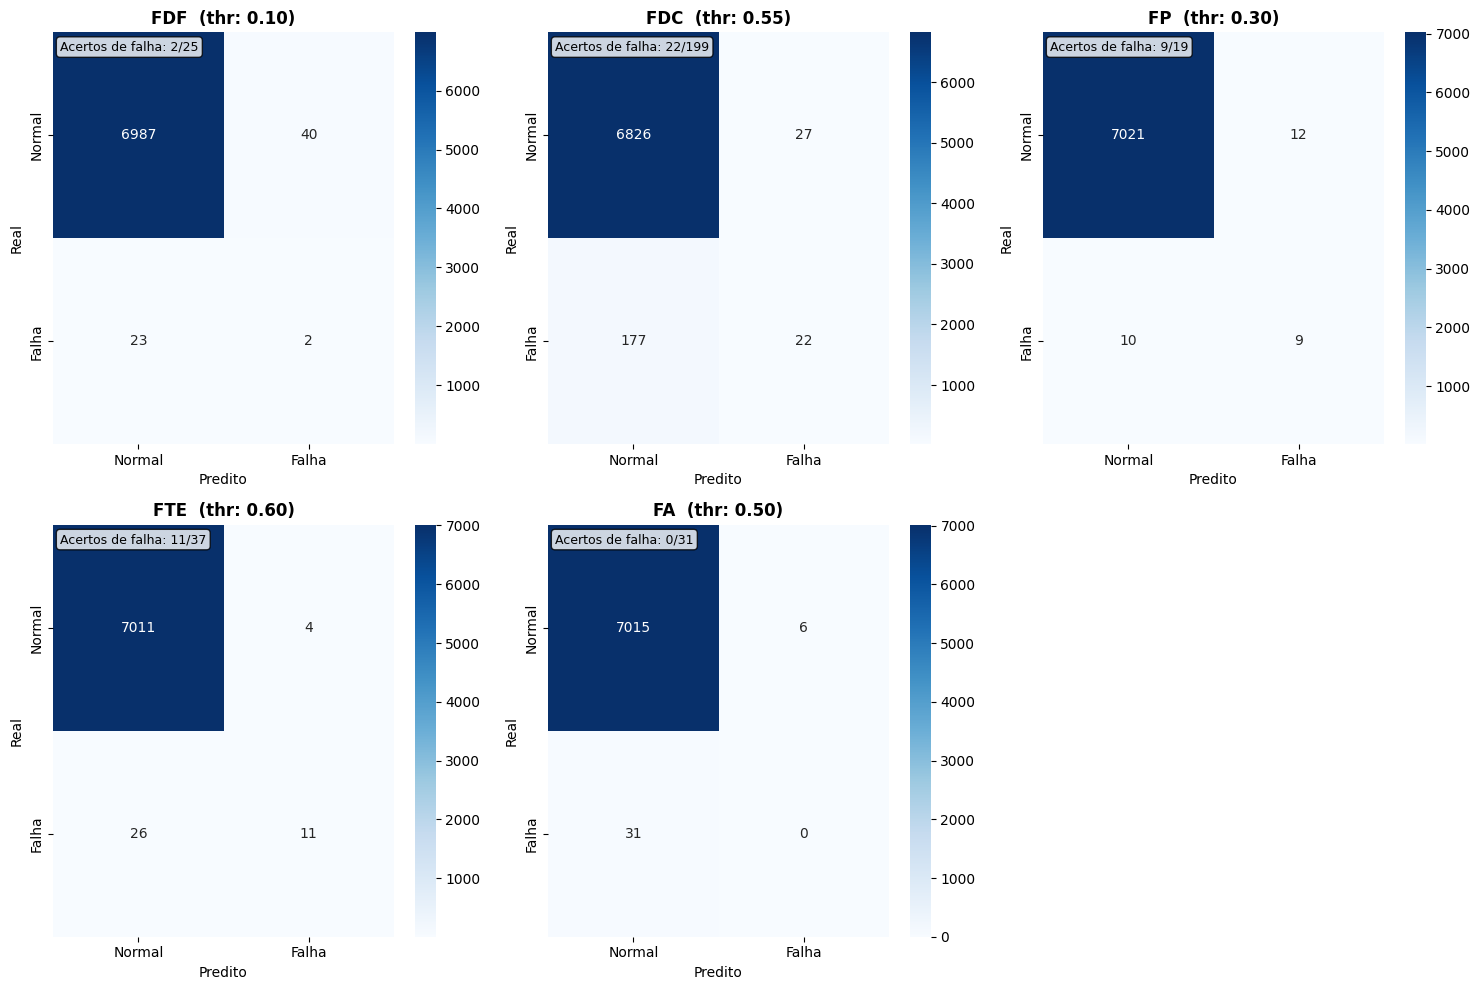

Leitura rápida:
- Diagonal = acertos
- Superior direito = falhas perdidas (ruim)
- Inferior esquerdo = falsos alarmes (aceitável até certo ponto)


In [10]:
# ===== 8. Matrizes de confusão =====
print("\n[8] Matrizes de confusão (após thresholds)")
print("-"*48)

# >>> CORREÇÃO: usar SEMPRE as probabilidades do modelo vencedor
y_pred_otimizado = np.zeros_like(y_test.values)
for i in range(len(failure_names)):
    y_pred_otimizado[:, i] = (melhor_pred_proba[:, i] >= thresholds_otimizados[i]).astype(int)

print("Erros por tipo (visualização):")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

from sklearn.metrics import confusion_matrix

for i, name in enumerate(failure_names):
    if i < 5:
        y_true_i = y_test.iloc[:, i]
        y_pred_i = y_pred_otimizado[:, i]
        cm = confusion_matrix(y_true_i, y_pred_i)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['Normal', 'Falha'], yticklabels=['Normal', 'Falha'])
        axes[i].set_title(f'{name}  (thr: {thresholds_otimizados[i]:.2f})', fontweight='bold')
        axes[i].set_xlabel('Predito')
        axes[i].set_ylabel('Real')

        # mini-interpretação no canto
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            if (tp + fn) > 0:
                texto = f"Acertos de falha: {tp}/{tp+fn}"
            else:
                texto = "Sem casos de falha no teste"
        else:
            texto = "Matriz não 2x2"
        axes[i].text(0.02, 0.98, texto, transform=axes[i].transAxes,
                     va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Remove o subplot extra
axes[5].remove()
plt.tight_layout()
plt.show()

print("Leitura rápida:")
print("- Diagonal = acertos")
print("- Superior direito = falhas perdidas (ruim)")
print("- Inferior esquerdo = falsos alarmes (aceitável até certo ponto)")

In [11]:
# ===== 9. Salvar modelo =====
print("\n[9] Salvando artefatos do modelo")
print("-"*28)

modelo_final_data = {
    'modelo_tipo': melhor_modelo_nome,
    'modelo': melhor_modelo,
    'scaler': joblib.load('../data/scaler.pkl'),
    'feature_names': feature_names,
    'failure_names': failure_names,
    'thresholds_otimizados': thresholds_otimizados,
    'f1_score_final': f1_final_avg,
    'performance_por_tipo': {failure_names[i]: f1_scores_otimizados[i] for i in range(len(failure_names))},
    'comparacao_modelos': {'Random Forest': rf_f1_avg, 'XGBoost': xgb_f1_avg, 'Vencedor': melhor_modelo_nome}
}

os.makedirs('../models', exist_ok=True)
joblib.dump(modelo_final_data, '../models/modelo_final_bootcamp.pkl')
print("Modelo salvo em: ../models/modelo_final_bootcamp.pkl")


[9] Salvando artefatos do modelo
----------------------------
Modelo salvo em: ../models/modelo_final_bootcamp.pkl


In [12]:
# ===== 10. Resumo =====
print("\n[10] Resumo final")
print("="*50)
print("Performance:")
print(f"- F1 médio final: {f1_final_avg:.3f}")
if baseline_f1_avg > 0:
    print(f"- Melhoria vs baseline: {f1_final_avg - baseline_f1_avg:.3f} ({((f1_final_avg - baseline_f1_avg)/baseline_f1_avg*100):.1f}%)")
else:
    print(f"- Melhoria vs baseline: {f1_final_avg - baseline_f1_avg:.3f} (baseline = 0)")
print(f"- Cross-Validation: {cv_mean:.3f} ± {cv_std:.3f}")

print("\nPor tipo:")
for i, name in enumerate(failure_names):
    casos_teste = y_test.iloc[:, i].sum()
    status = "OK" if f1_scores_otimizados[i] > 0.2 else "Atenção" if f1_scores_otimizados[i] > 0 else "Ruim"
    print(f"- {name}: F1={f1_scores_otimizados[i]:.3f} ({casos_teste} casos) [{status}]")

print("\nPróximos passos:")
print("1) Notebook 3: análise de negócio/ROI")
print("2) Preparar apresentação focando em decisão e trade-offs")
print("3) Rodar piloto e ajustar limites por ambiente/linha")


[10] Resumo final
Performance:
- F1 médio final: 0.222
- Melhoria vs baseline: 0.222 (baseline = 0)
- Cross-Validation: 0.230 ± 0.008

Por tipo:
- FDF: F1=0.060 (25 casos) [Atenção]
- FDC: F1=0.177 (199 casos) [Atenção]
- FP: F1=0.450 (19 casos) [OK]
- FTE: F1=0.423 (37 casos) [OK]
- FA: F1=0.000 (31 casos) [Ruim]

Próximos passos:
1) Notebook 3: análise de negócio/ROI
2) Preparar apresentação focando em decisão e trade-offs
3) Rodar piloto e ajustar limites por ambiente/linha
